Our libraries and imports:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, label_binarize
from sklearn.multiclass import OneVsRestClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.calibration import label_binarize
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, train_test_split, KFold, GridSearchCV ,StratifiedKFold, learning_curve

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, precision_recall_curve
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline

# Dataset description

In [2]:
df = pd.read_csv("NHANES_age_prediction.csv")
df.head()

,SEQN,age_group,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
0,73564.0,Adult,61.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,Adult,26.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,Adult,16.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,Adult,32.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,Adult,38.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


In [3]:
df.describe()

,SEQN,RIDAGEYR,RIAGENDR,PAQ605,BMXBMI,LBXGLU,DIQ010,LBXGLT,LBXIN
count,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000,2278.000000
mean,78691.853819,41.795874,1.511414,1.822651,27.955180,99.553117,2.016242,114.978929,11.834794
std,2921.365151,20.156111,0.499979,0.398918,7.248962,17.889834,0.185556,47.061239,9.718812
min,73564.000000,12.000000,1.000000,1.000000,14.500000,63.000000,1.000000,40.000000,0.140000
25%,76171.750000,24.000000,1.000000,2.000000,22.800000,91.000000,2.000000,87.000000,5.860000
50%,78749.000000,41.000000,2.000000,2.000000,26.800000,97.000000,2.000000,105.000000,9.040000
75%,81213.500000,58.000000,2.000000,2.000000,31.200000,104.000000,2.000000,130.000000,14.440000
max,83727.000000,80.000000,2.000000,7.000000,70.100000,405.000000,3.000000,604.000000,102.290000


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2278 entries, 0 to 2277
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   SEQN       2278 non-null   float64
 1   age_group  2278 non-null   object 
 2   RIDAGEYR   2278 non-null   float64
 3   RIAGENDR   2278 non-null   float64
 4   PAQ605     2278 non-null   float64
 5   BMXBMI     2278 non-null   float64
 6   LBXGLU     2278 non-null   float64
 7   DIQ010     2278 non-null   float64
 8   LBXGLT     2278 non-null   float64
 9   LBXIN      2278 non-null   float64
dtypes: float64(9), object(1)
memory usage: 178.1+ KB


In [5]:
print("\nMissing Values:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


Missing Values:
 SEQN         0
age_group    0
RIDAGEYR     0
RIAGENDR     0
PAQ605       0
BMXBMI       0
LBXGLU       0
DIQ010       0
LBXGLT       0
LBXIN        0
dtype: int64

Duplicate Rows: 0


* Our dataset is based on data from the National Health and Nutrition Examination Survey, it contains medical tests of participants and based on them we aim to predict the `age_group` of the participant.
* Overall there are 2278 instances, no null values and duplicate rows.
* All features are type float64, but the `age_group` is category.

# Transforming the dataset

### Our Feature Engineering:
##### Creating "Young" group and Dropping Age column
If we keep the age column in the dataset, models will use it to guess the answer, it leads to **data leakage** because these models seem pretty accurate at training but in real cases they will fail the performance on new data.

In [6]:
df['age_group'] = df.apply(lambda row: 'Young' if 12 <= row['RIDAGEYR'] <= 25 else row['age_group'], axis=1)

df = df.drop('RIDAGEYR', axis=1)

#### Renaming the columns for clearer understanding of data

In [7]:
df.rename(columns={
    'SEQN': 'ID',
    'RIAGENDR': 'gender',
    'PAQ605': 'physical_activity',
    'BMXBMI': 'bmi',
    'LBXGLU': 'glucose',
    'DIQ010': 'diabetes_status',
    'LBXGLT': 'glucose_tolerance',
    'LBXIN': 'insulin'
}, inplace=True)

#### Converting age_group into numeric value for future using

In [8]:
categories_order = [['Young', 'Adult', 'Senior']]
ordinal_encoder = OrdinalEncoder(categories=categories_order)
df['age_group'] = ordinal_encoder.fit_transform(df[['age_group']])

#### Choosing color palette

In [9]:
sns.set_palette("deep")

# Data Analysis
##### Our new head:

In [10]:
df.head()

,ID,age_group,gender,physical_activity,bmi,glucose,diabetes_status,glucose_tolerance,insulin
0,73564.0,1.0,2.0,2.0,35.7,110.0,2.0,150.0,14.91
1,73568.0,1.0,2.0,2.0,20.3,89.0,2.0,80.0,3.85
2,73576.0,0.0,1.0,2.0,23.2,89.0,2.0,68.0,6.14
3,73577.0,1.0,1.0,2.0,28.9,104.0,2.0,84.0,16.15
4,73580.0,1.0,2.0,1.0,35.9,103.0,2.0,81.0,10.92


### Distrubution graphs

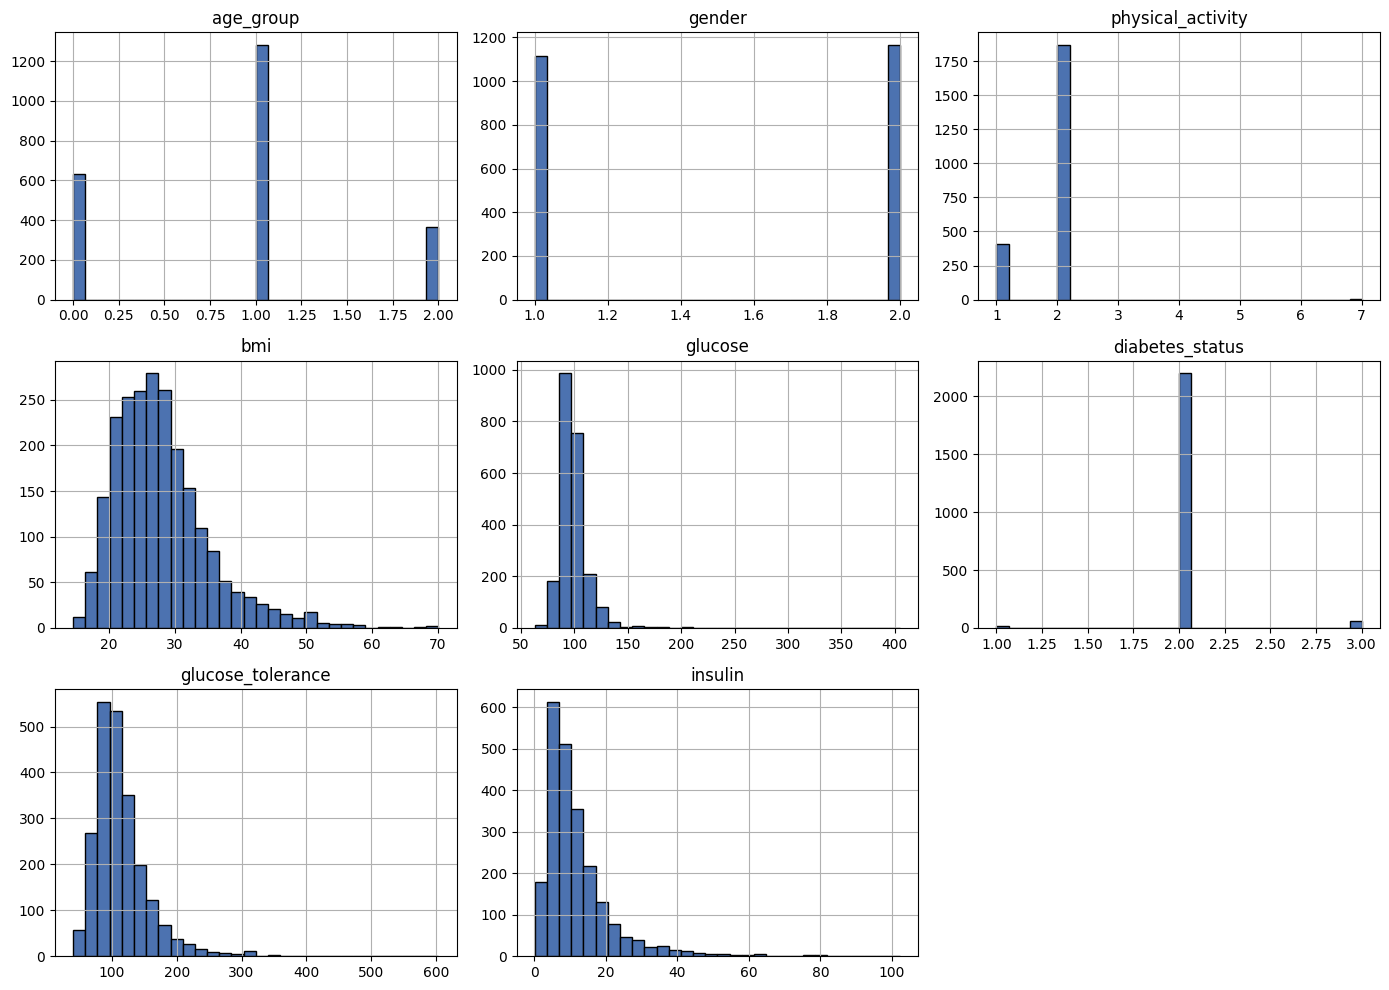

In [11]:
plot_columns = df.drop(columns='ID').columns
df[plot_columns].hist(figsize=(14, 10), bins=30, edgecolor='black')
plt.tight_layout()
plt.show()

* `bmi`, `glucose`, `glucose_tolerance`, and `insulin` have almost the same distributions because they depend from each other. And all of the high counts are in the middle, it means most of the participants have normal indicators of these tests.
* Distribution of `physical_activity` shows that most of the participants do not excercise or do sports.
* Distribution of `diabetes_status` tells us that almost all of the participants do not have diabetes.
* Distribution of `age_group` shows that most of the participants are in the Adult age group.

### Correlation map

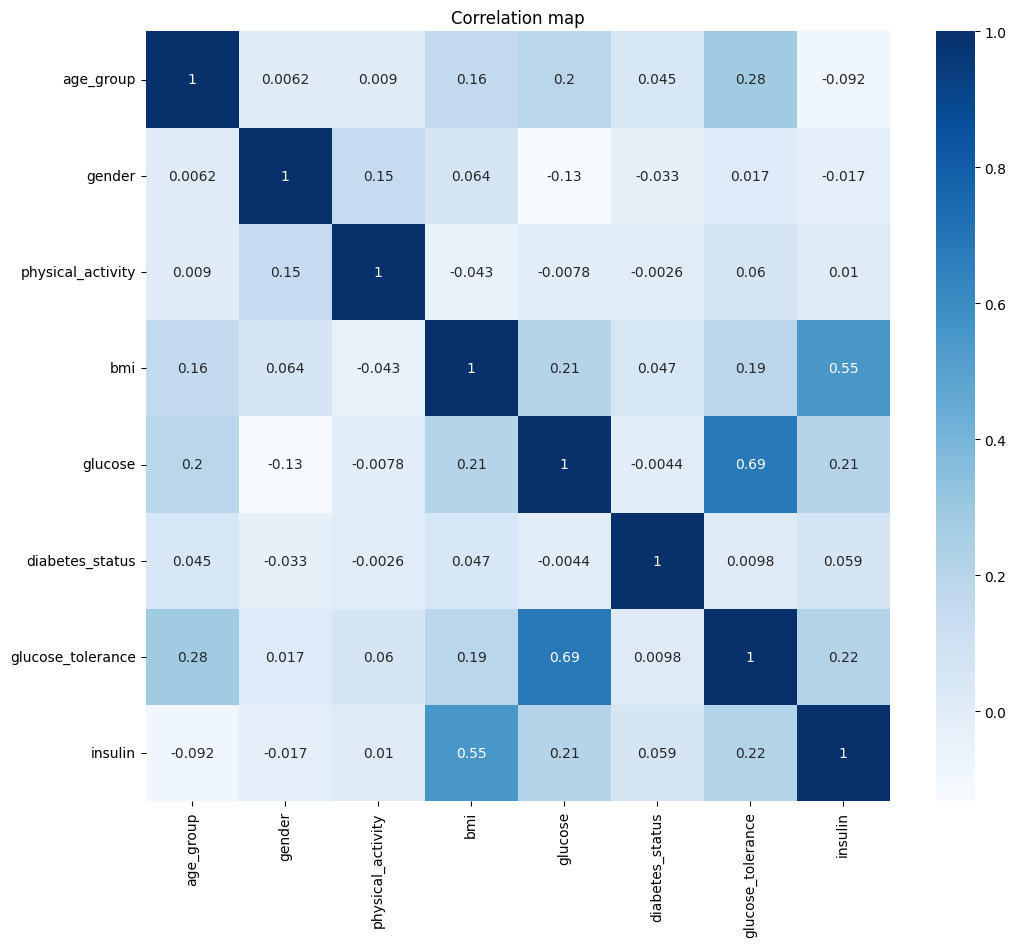

In [12]:
corr= df[plot_columns].corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation map")
plt.show()

* On the correlation map we can see high correlation between `glucose` and `glucose_tolerance` **(0.69)**, `bmi` and `insulin` **(0.55)**. First one is because if people have high glucose it means that they have poor glucose tolerance, the second tells us that heavier people tend to have higher insulin.
* Medium **(0.21),(0.19)** correlation of `bmi` with `glucose` and `glucose_torelance` - weight effect on glucose levels; and at the same level **(0.19),(0.16)** correlation of `age_group` between `glucose` and `bmi`, probably because olderly people have higher weight and glucose level.
* Also medium correlation between `age_group` and `glucose_level` **(0.28)** because glucose processing changes with age
* No strong correlations with `age_group` `physical_activity`, `diabetes_status`, `gender` are seen, because they are more **categorical variable**.

### Pair plots for `age_group` and numerical values

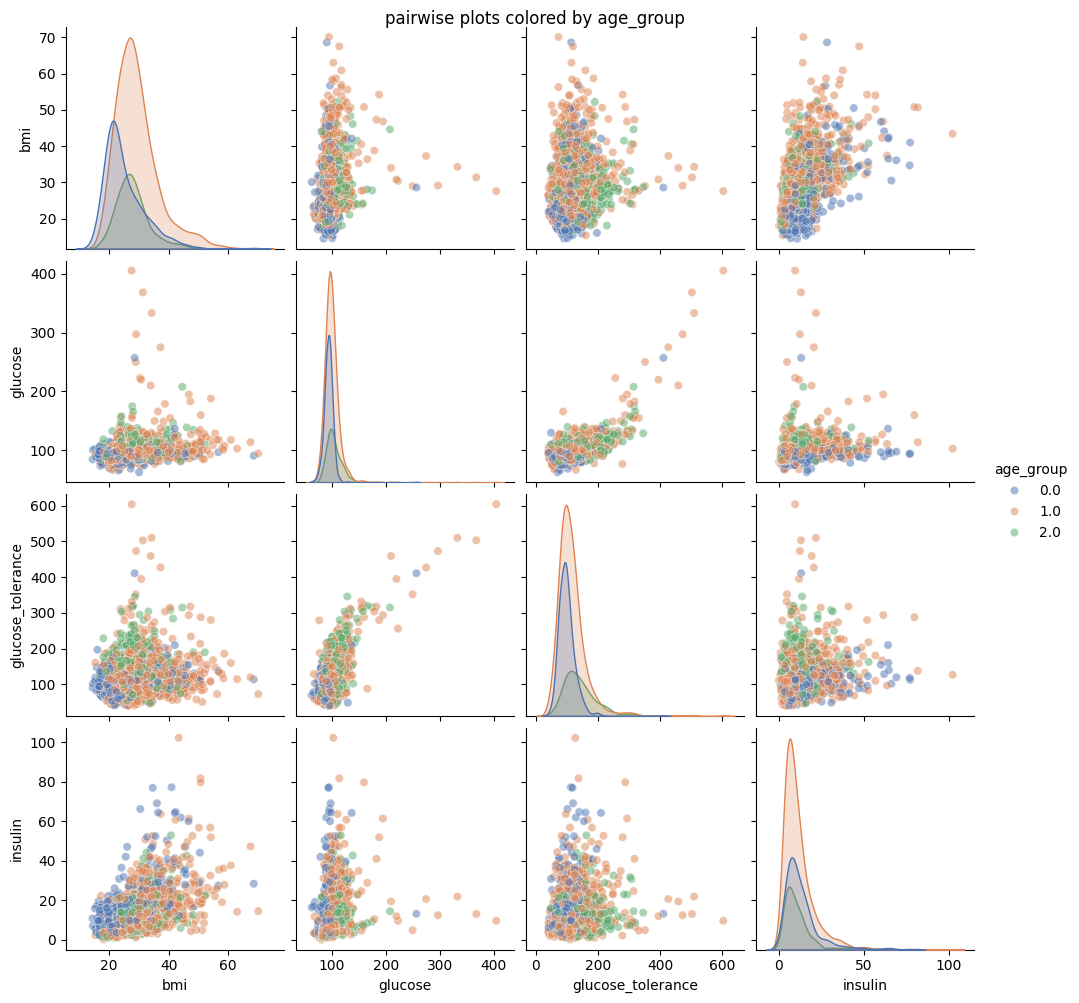

In [13]:
sns.pairplot(
    df,
    vars=['bmi', 'glucose', 'glucose_tolerance', 'insulin'],
    hue='age_group',
    palette='deep',
    plot_kws={'alpha': 0.5}
)
plt.suptitle("pairwise plots colored by age_group", y=1)
plt.show()

* We used **pair plots** to see more detailed correlation between all numerical values, but most important to watch the correlation of `age_group` with them, figure out will they be helpful to predict `age_group` and which variable pairs are most improtant for that.
* `bmi` is bigger in younger and adult groups and smaller in senior; `glucose` and `glucose_tolerance` show increasing trends with `age_group`, while `insulin` levels decrease.
* From this plots we found out that these values are helpful for `age_group` prediction because they reflect changes that occur with aging. `insulin` can help improve predictions, especially when combined with other values and `glucose` and `glucose_tolerance` are most useful because they show upward trends with age.

### Count plots for `age_group` and categorical values

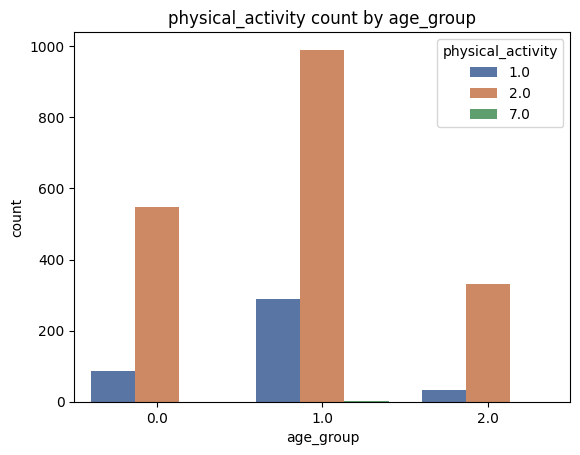

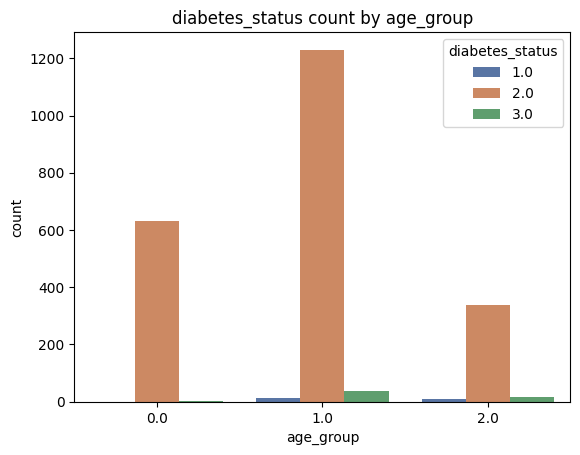

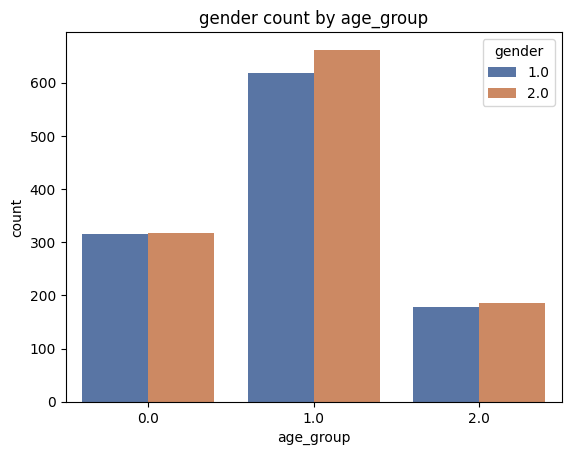

In [14]:
def countplot(df, cols):
    import seaborn as sns
    import matplotlib.pyplot as plt

    for col in cols:
        sns.countplot(x='age_group', hue=col, data=df, palette='deep')
        plt.title(f'{col} count by age_group')
        plt.legend(title=col)
        plt.show()

countplot(df, ['physical_activity', 'diabetes_status', 'gender'])

* We used **count plots** with the same main reason - to see what values will be more helpful to predict `age_group`.
* And from these plots we see that `diabetes_status` is clearly related to age. Most participants from young group don’t have diabetes and older groups have not a lot of cases too, but more. This makes it a good feature for predicting `age_group`. `physical_activity` is the same across age groups, but young group slightly more active. `gender` is nearly equal on all age groups.

### Checking and dropping outliers

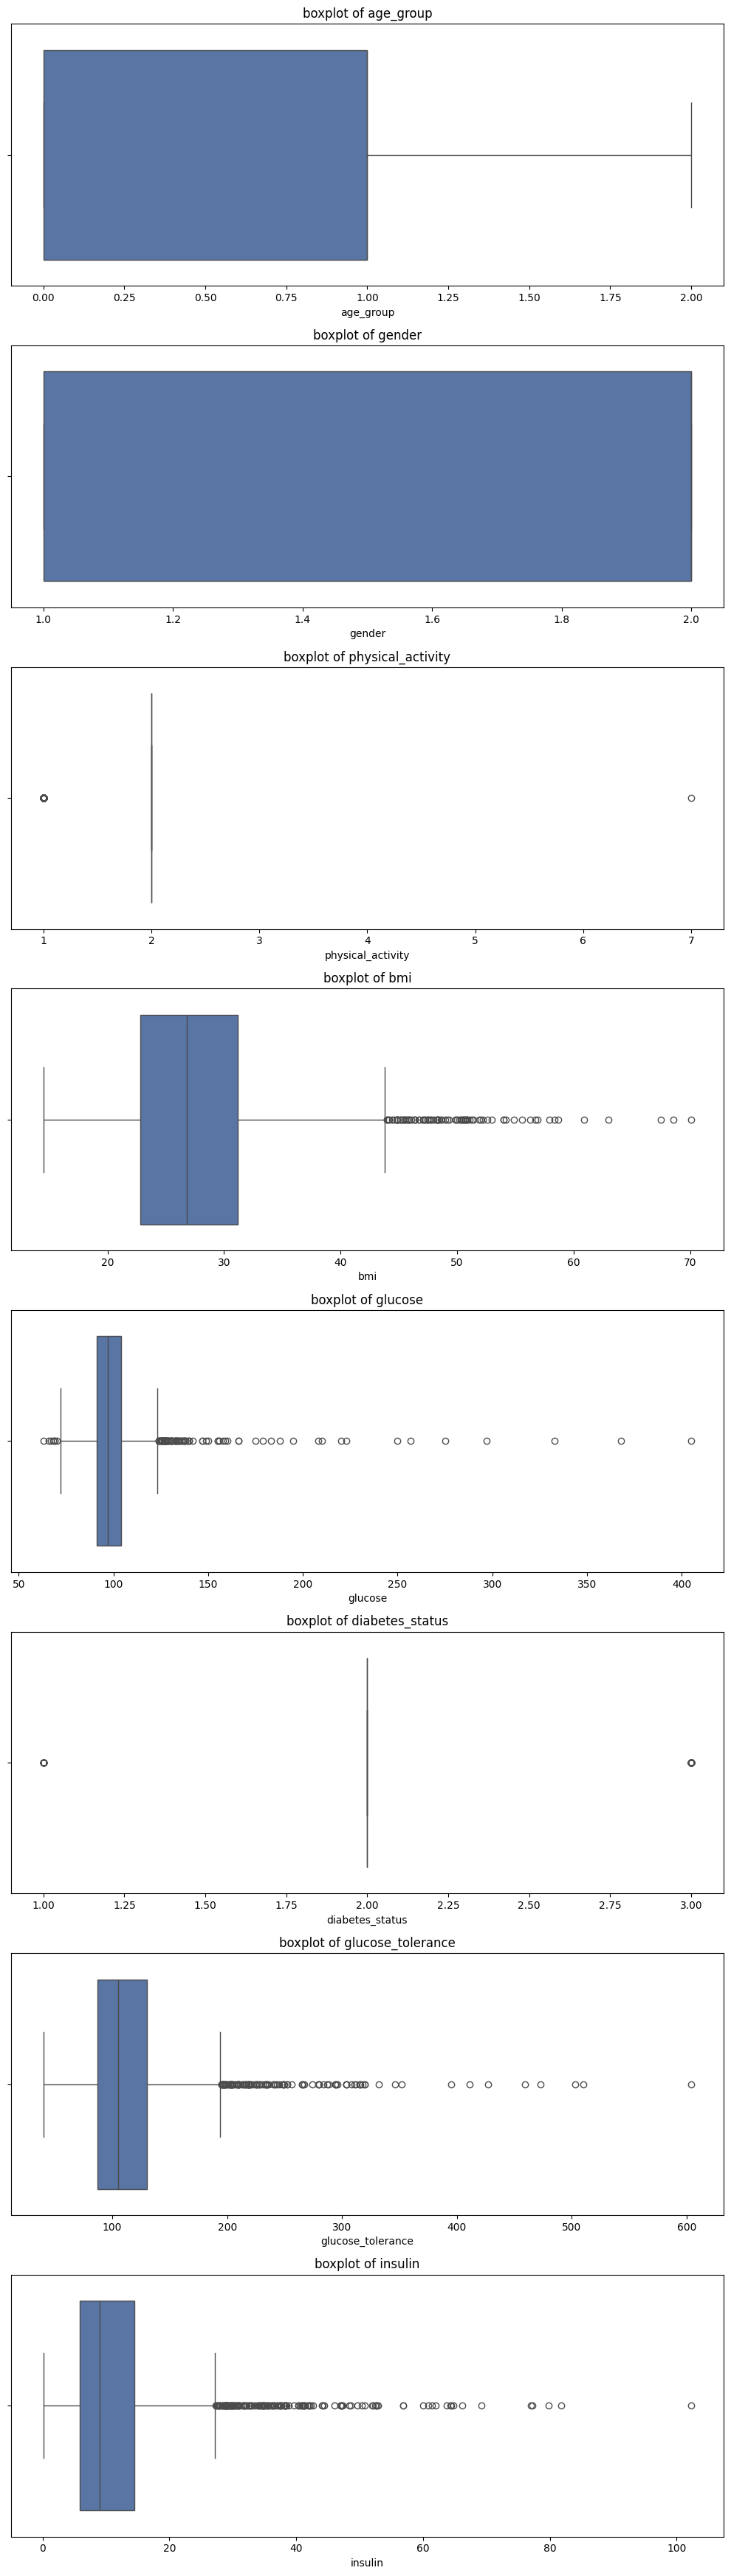

In [15]:
def check_outliers(df):
    fig, axs = plt.subplots(len(df[plot_columns].columns), 1, figsize=(10, 35))
    for i, col in enumerate(df[plot_columns].columns):
        sns.boxplot(x=df[col], ax=axs[i])
        axs[i].set_title(f'boxplot of {col}')
    plt.tight_layout()
    plt.show()

check_outliers(df)

* From the investigation that we have done before, we can say that the `glucose`, `glucose_tolerance`,`insulin` and `diabetes_status` values are very important to prediction of `age_group`, and their outliers can indicate important health conditions that vary across age groups. So we decided to keep them.

In [16]:
def drop_outliers(df, columns):
    exclude = ['glucose', 'glucose_tolerance', 'diabetes_status', 'insulin']
    for col in columns:
        if col not in exclude:
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr = q3 - q1
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            df = df[(df[col] >= lower) & (df[col] <= upper)]
    return df

num_cols = df.select_dtypes(include=np.number).columns

df = drop_outliers(df, num_cols)

### Data Scaling

In [17]:
scaler = StandardScaler()
values_to_remove = ['age_group', 'gender', 'physical_activity', 'diabetes_status']
num_cols = num_cols[~num_cols.isin(values_to_remove)]
df[num_cols] = scaler.fit_transform(df[num_cols])

#### Splitting data into input features(X) and target variable(y).

In [18]:
X = df.drop(columns = 'age_group')
y = df['age_group']

# Model training and evaluation

#### Function to tune parameters of selected model.

In [19]:
def tune_hyperparams(model, param_grid, X_train, y_train):
    rfecv = RFECV(estimator=model, cv=5, scoring='accuracy')
    pipeline = Pipeline([
        ('feature_selection', rfecv),
        ('classification', model)
    ])
    grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=StratifiedKFold(10), scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    print(grid_search.best_params_)
    

* Here we're tuning parameters for classification models in order to maximize accuracy. We've chosen several models, even though some of then couldn't be tuned using Grid Search.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

model = LogisticRegression()

model = KNeighborsClassifier()# cannot tune params

model = DecisionTreeClassifier(random_state=0)

model = RandomForestClassifier(random_state=0)

model = SVC() # cannot tune params

model = GaussianNB() # cannot tune params

model = GradientBoostingClassifier(ccp_alpha= 0.01, loss= 'log_loss', max_depth= 2)

param_grid = {
    'classification__max_depth': [3, 5, 10, None],
    'classification__min_samples_split': [2, 5, 10],
    'classification__min_samples_leaf': [1, 2, 4],
    'classification__max_features': ['sqrt', 'log2', None]
}

# tune_hyperparams(model, param_grid, X_train, y_train)

* After tuning the parameters, we start to train and fit our models. Then, we collect metrics like accuracy, precision, etc. in order to choose best performing model and also we store data to plot ROC AUC curve.

In [21]:
models = {
    'Logistic Regression (saga)': LogisticRegression(C=0.1, max_iter=200, penalty='l1', solver='saga'),
    'K-Neighbors Classifier': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=10, max_features='log2', random_state=0),
    'Random Forest': RandomForestClassifier(min_samples_leaf=2, min_samples_split=2, max_features='sqrt', random_state=0, n_estimators=100),
    'GaussianNB': GaussianNB(),
    'Gradient Boosting': GradientBoostingClassifier(loss='log_loss',min_samples_split=2, min_samples_leaf=2, max_depth=2)
}

results = {}

n_models = len(models)
n_cols = 3
n_rows = (n_models + n_cols - 1) // n_cols

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_test, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    train_sizes, train_scores, validation_scores = learning_curve(model, X_train, y_train, cv=5)
    
    y_test_bin = label_binarize(y_test, classes=[0.0, 1.0, 2.0]) 
    n_classes = y_test_bin.shape[1]
    fpr, tpr, roc_auc, precision_c, recall_c = {}, {}, {}, {}, {}
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        precision_c[i], recall_c[i], _ = precision_recall_curve(y_test_bin[:, i], model.predict_proba(X_test)[:, i])

    
    results[model_name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'fpr': fpr, 
        'tpr': tpr,
        'roc_curve': roc_auc,
        'precision_curve': precision_c,
        'recall_curve': recall_c,
        'train_sizes':train_sizes,
        'train_scores':train_scores,
        'validation_scores': validation_scores
        
    }


#### Plot accuracy, precision, recall and f1 for each model.

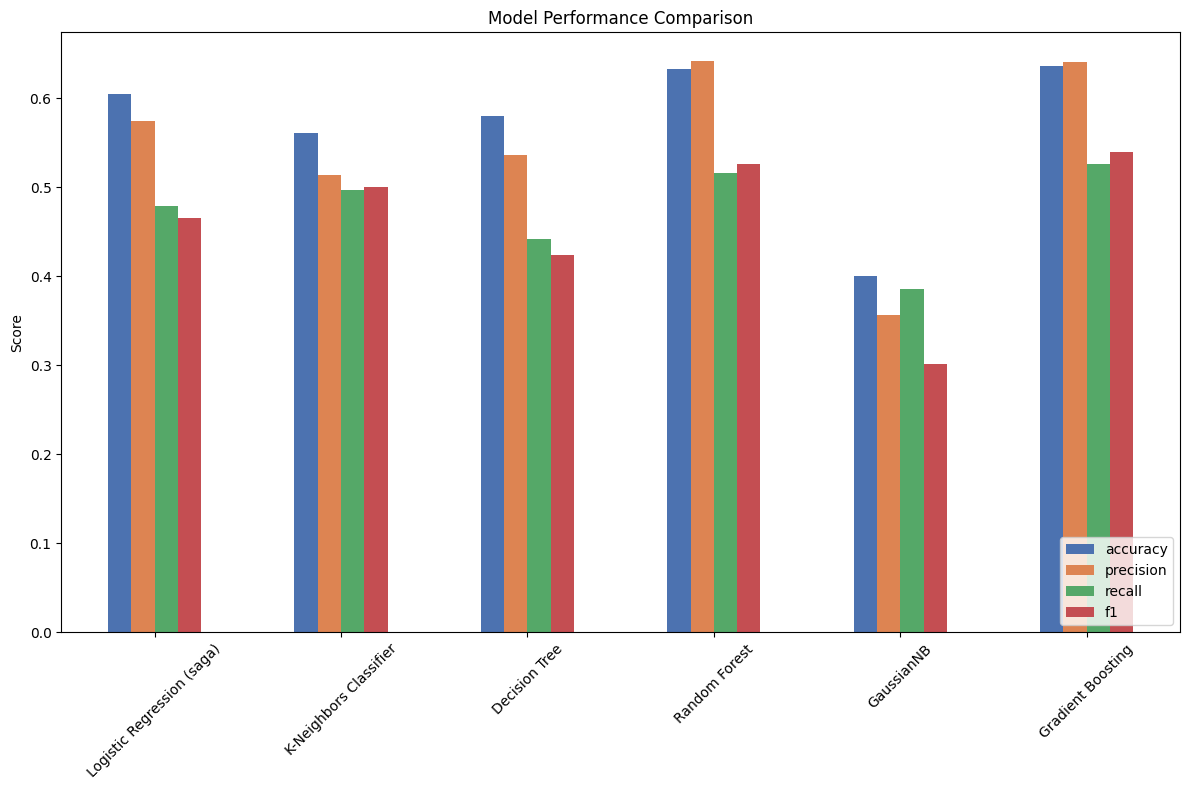

In [22]:
metrics_df = pd.DataFrame(results).T
metrics_df[['accuracy', 'precision', 'recall', 'f1']].plot(kind='bar', figsize=(12, 8))
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.legend(loc='lower right')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

* `Logistic Regression` shows decent perfomance across accuracy and precision and somewhat lower recall and f1 score, which applies to all other models. 

* `K-Neighbors Classifier` has lower accuracy and precision scores, but achieves a slight increase in recall and f1.

* `Decision Tree` was expected to perform the best, but it seems to *overfit* the training data. Usually it gives high accuracy but lower recall and precision in multi-class problems.

* `Random Forest` has one of the best metrics accross all models and is a way of solving overfitting problem with Decision Tree as it aggregates multiple DT's, reducing variance.

* `Gaussian NB` tends to perform poorly, and we think it's because our features are normally distributed and the model give suboptimal results in most of the cases.

* `Gradient Boosting` performs a little bit better than Random Forest, mainly because this model add learners sequentialy, correcting mistakes of previous ones.

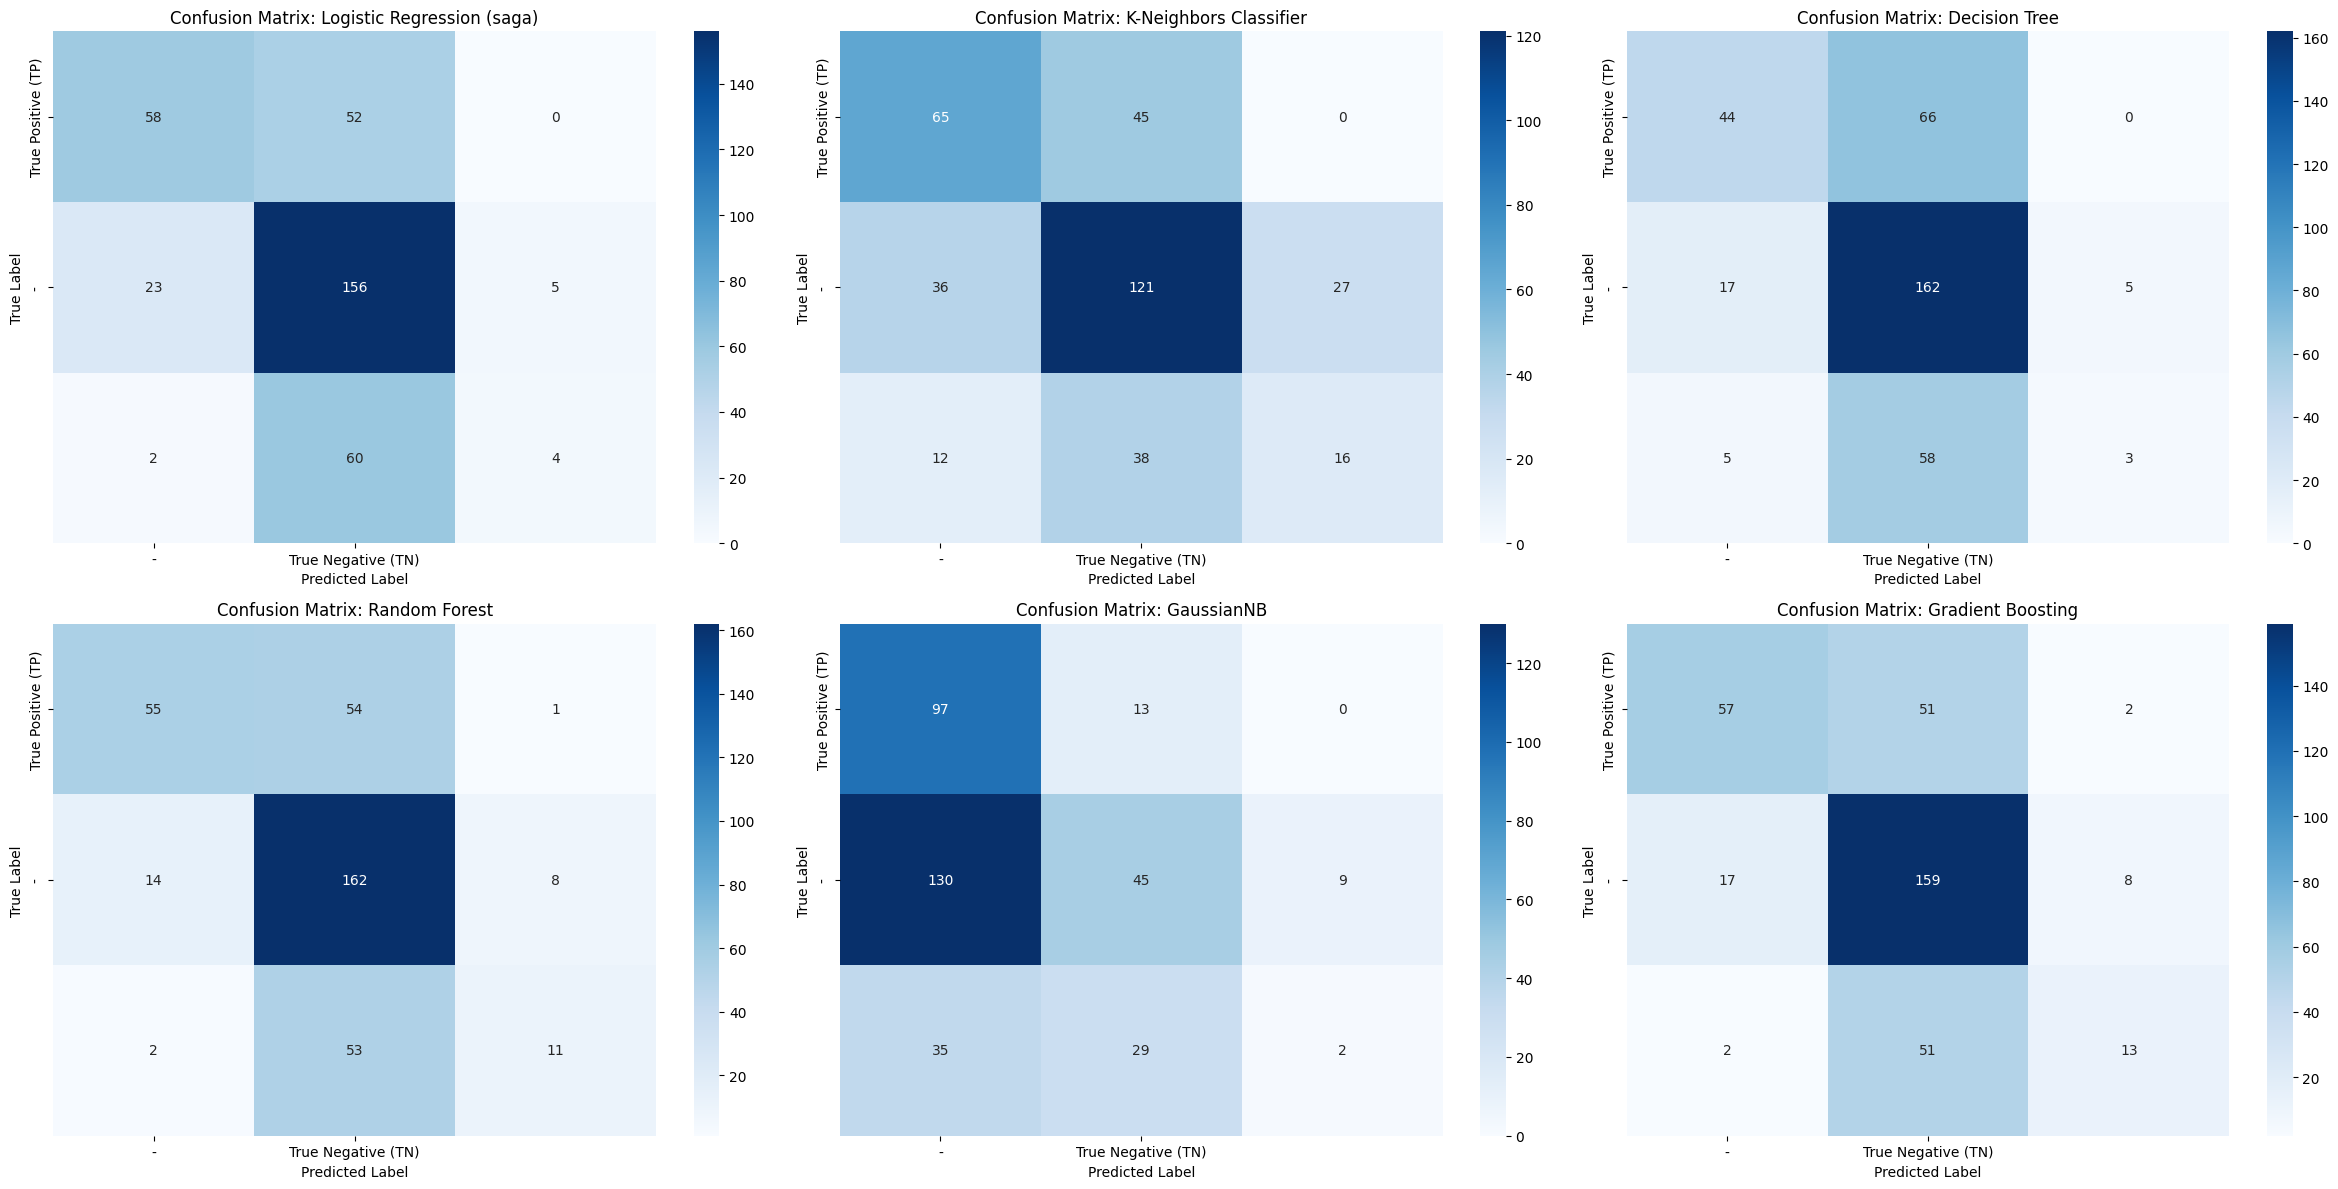

In [23]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
labels = ['-', 'True Negative (TN)', 'True Positive (TP)', '-']
for i, model_name in enumerate(models.keys()):
    cm = results[model_name]['confusion_matrix']
    cm_reshaped = cm.reshape(3, 3)
    sns.heatmap(cm_reshaped, annot=True, fmt='d', cmap='Blues', 
                xticklabels=labels[:2], yticklabels=labels[2:], ax=axes[i])  
    axes[i].set_title(f'Confusion Matrix: {model_name}')
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


* Focusing on important points here, we can see that `K-Neighbors` and `Decision Tree` show higher number of missclassifications and false positives, which is a result of overfitting training data. 
* `Gradient Boosting` have the best performance overall, with noticeable number of true positives and lower number of false positives.

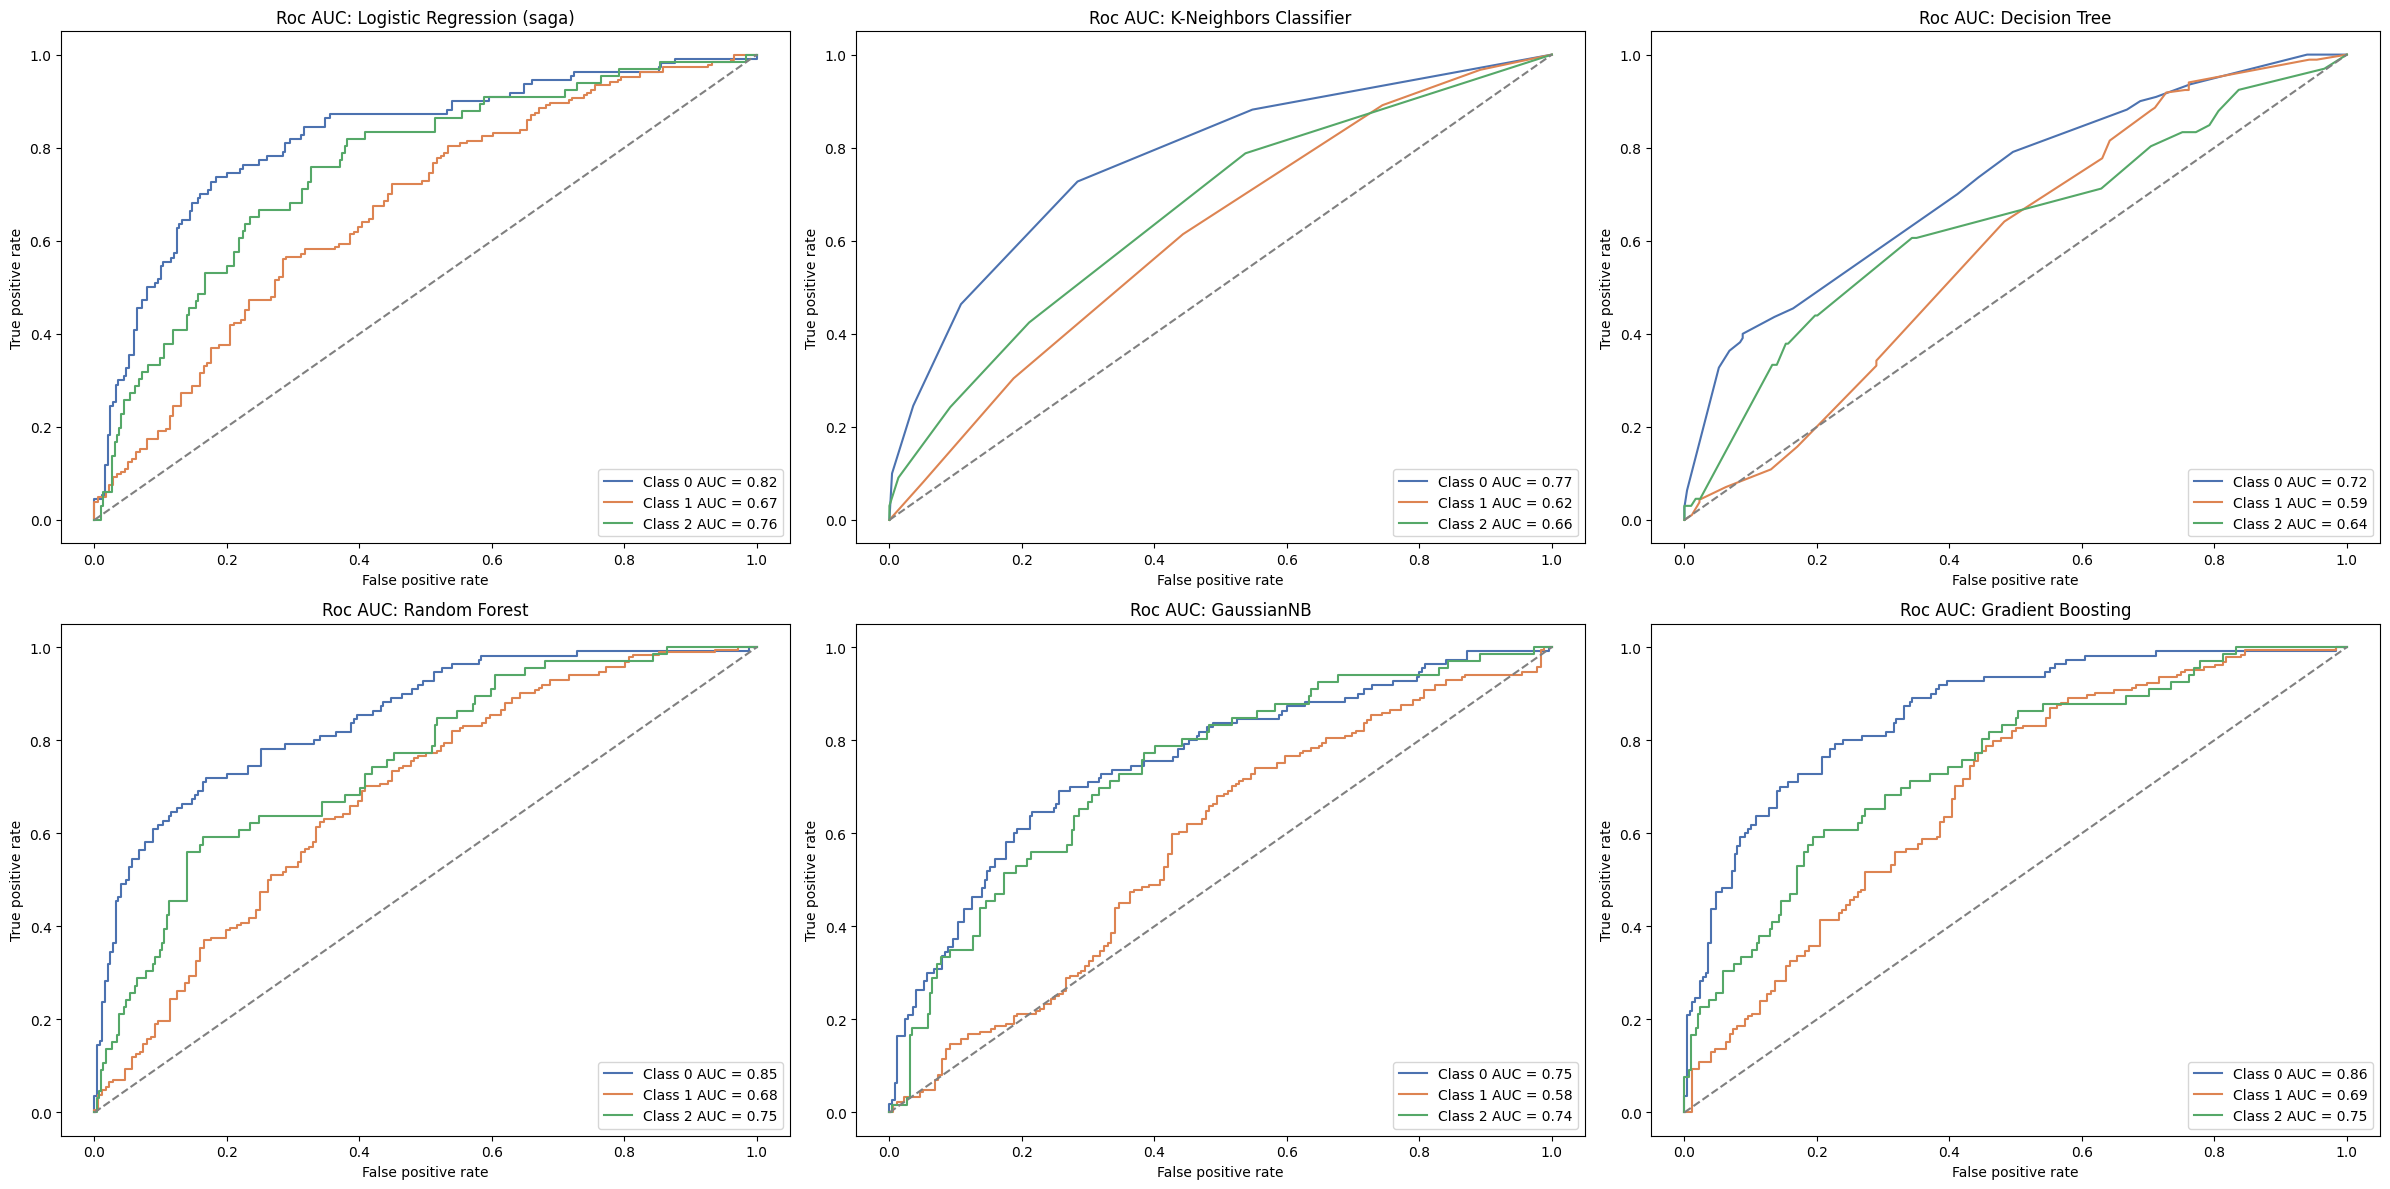

In [24]:

fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    fpr = results[model_name]['fpr']
    tpr = results[model_name]['tpr']
    roc_auc = results[model_name]['roc_curve']
    for j in range(n_classes):
        axes[i].plot(fpr[j], tpr[j], label=f'Class {j} AUC = {roc_auc[j]:.2f}')
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')
    axes[i].set_title(f'Roc AUC: {model_name}')
    axes[i].set_xlabel('False positive rate')
    axes[i].set_ylabel('True positive rate')
    axes[i].legend(loc='lower right')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


* At first, there's not much to tell from these plots, but we can surely say that `Random Forest` and `Gradient Boosting ` have highest AUCs across all classes, meaning they can distinguish between classes betteer than other models

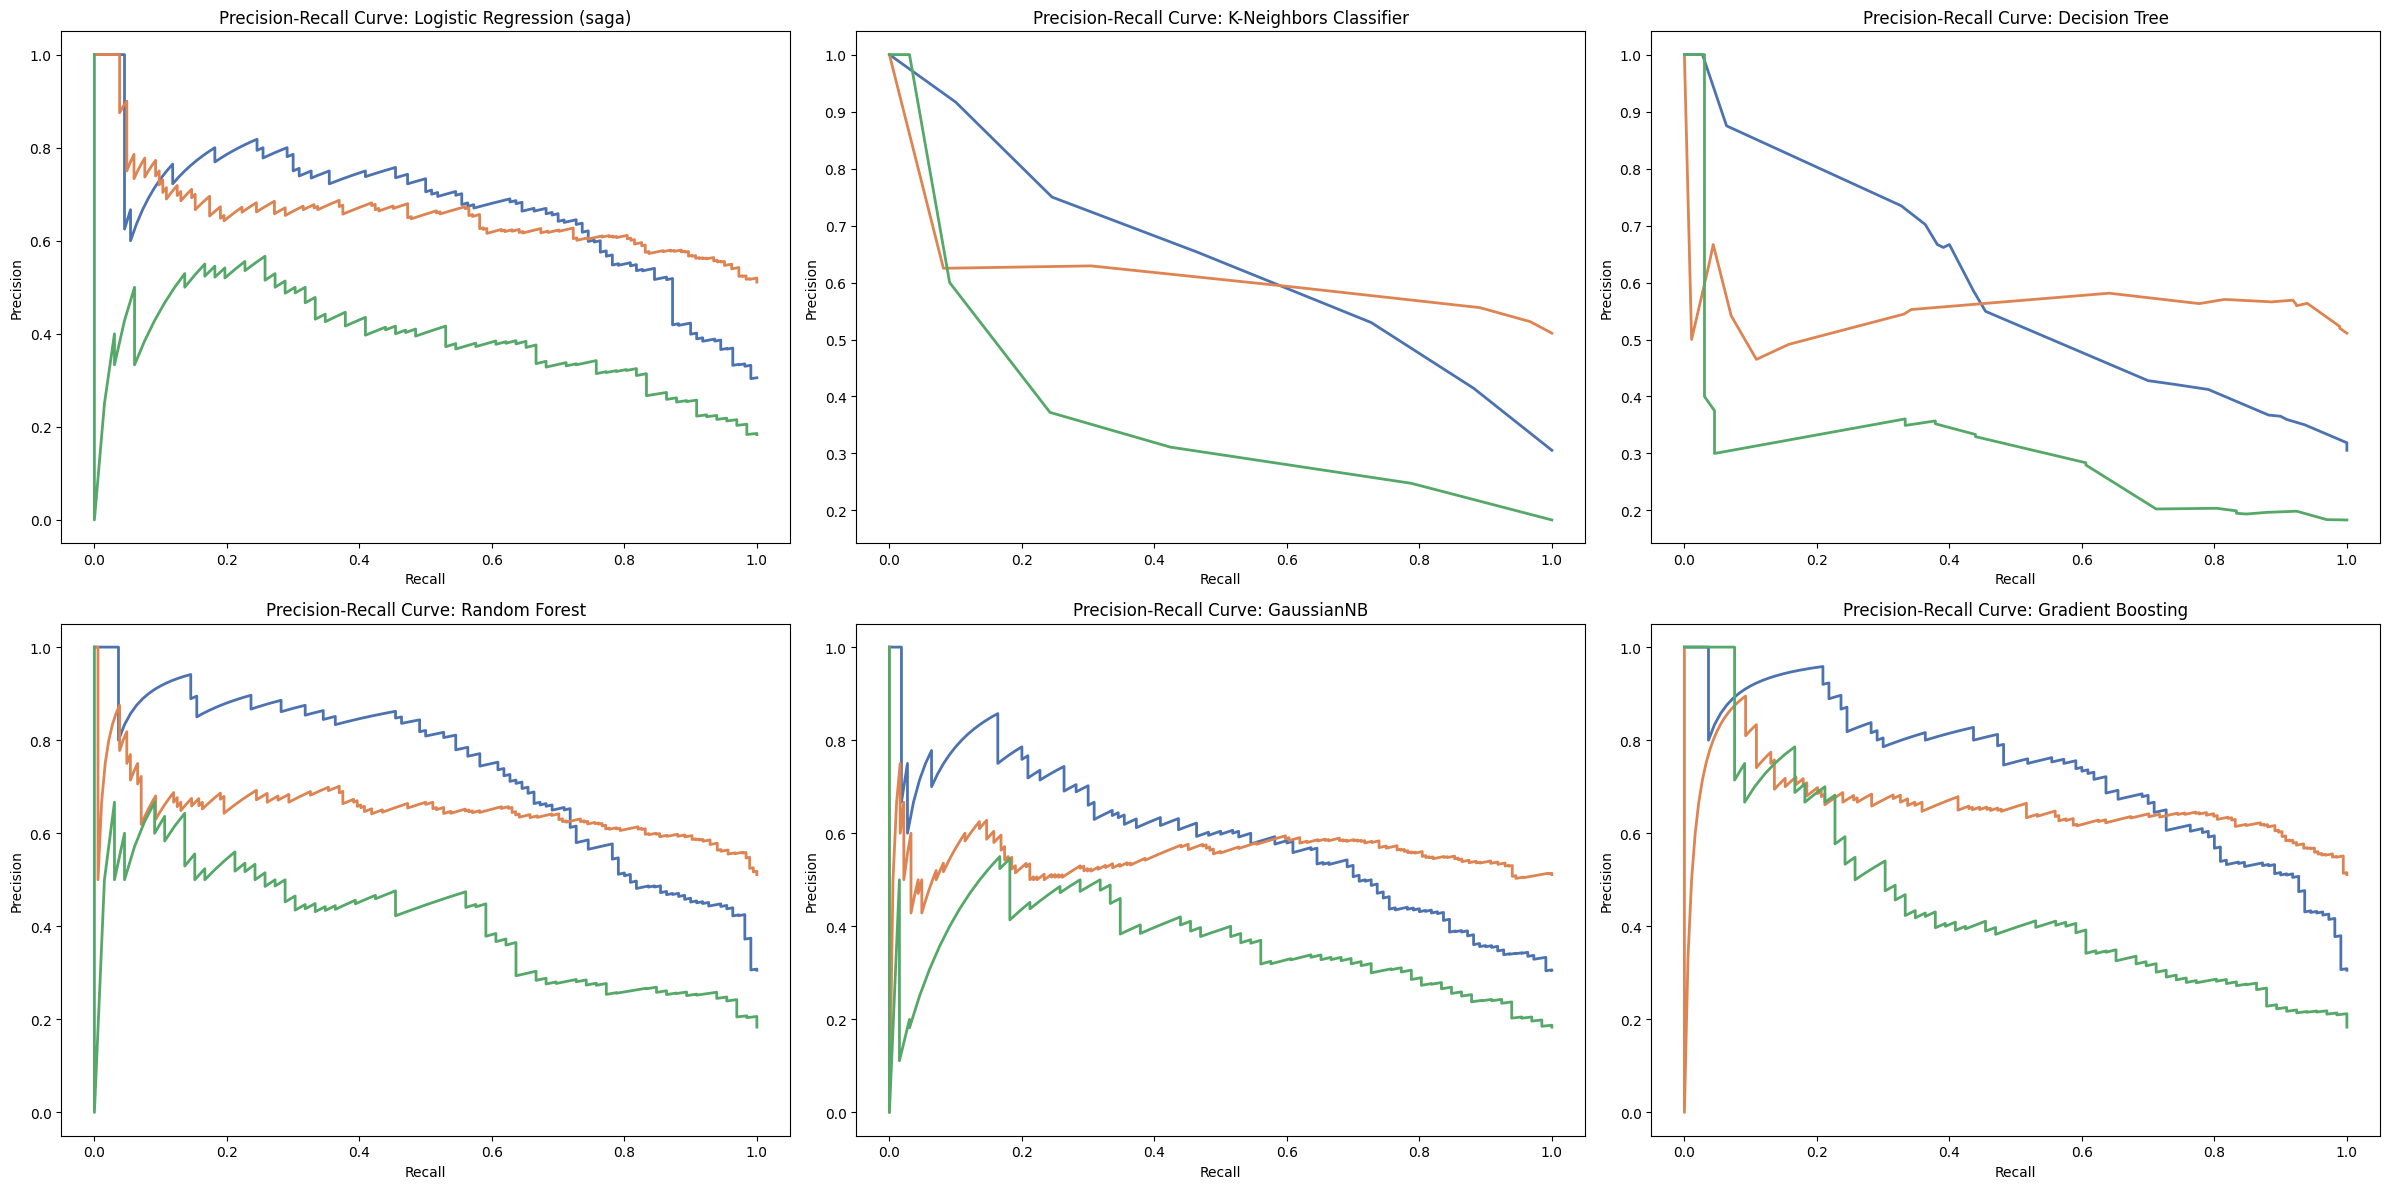

In [25]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    recall = results[model_name]['recall_curve']
    precision = results[model_name]['precision_curve']
    for j in range(n_classes):
        axes[i].plot(recall[j], precision[j], lw=2)
    axes[i].set_title(f'Precision-Recall Curve: {model_name}')
    axes[i].set_xlabel('Recall')
    axes[i].set_ylabel('Precision')
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

* Looking at these graphs tells us that `K-Neighbors Classifier `and `Decision Tree` may need more tuning or other approaches as they rapidly lose precision as recall increases. Other approaches may be futher class balancing or re-sampling, as well as additional tunning.

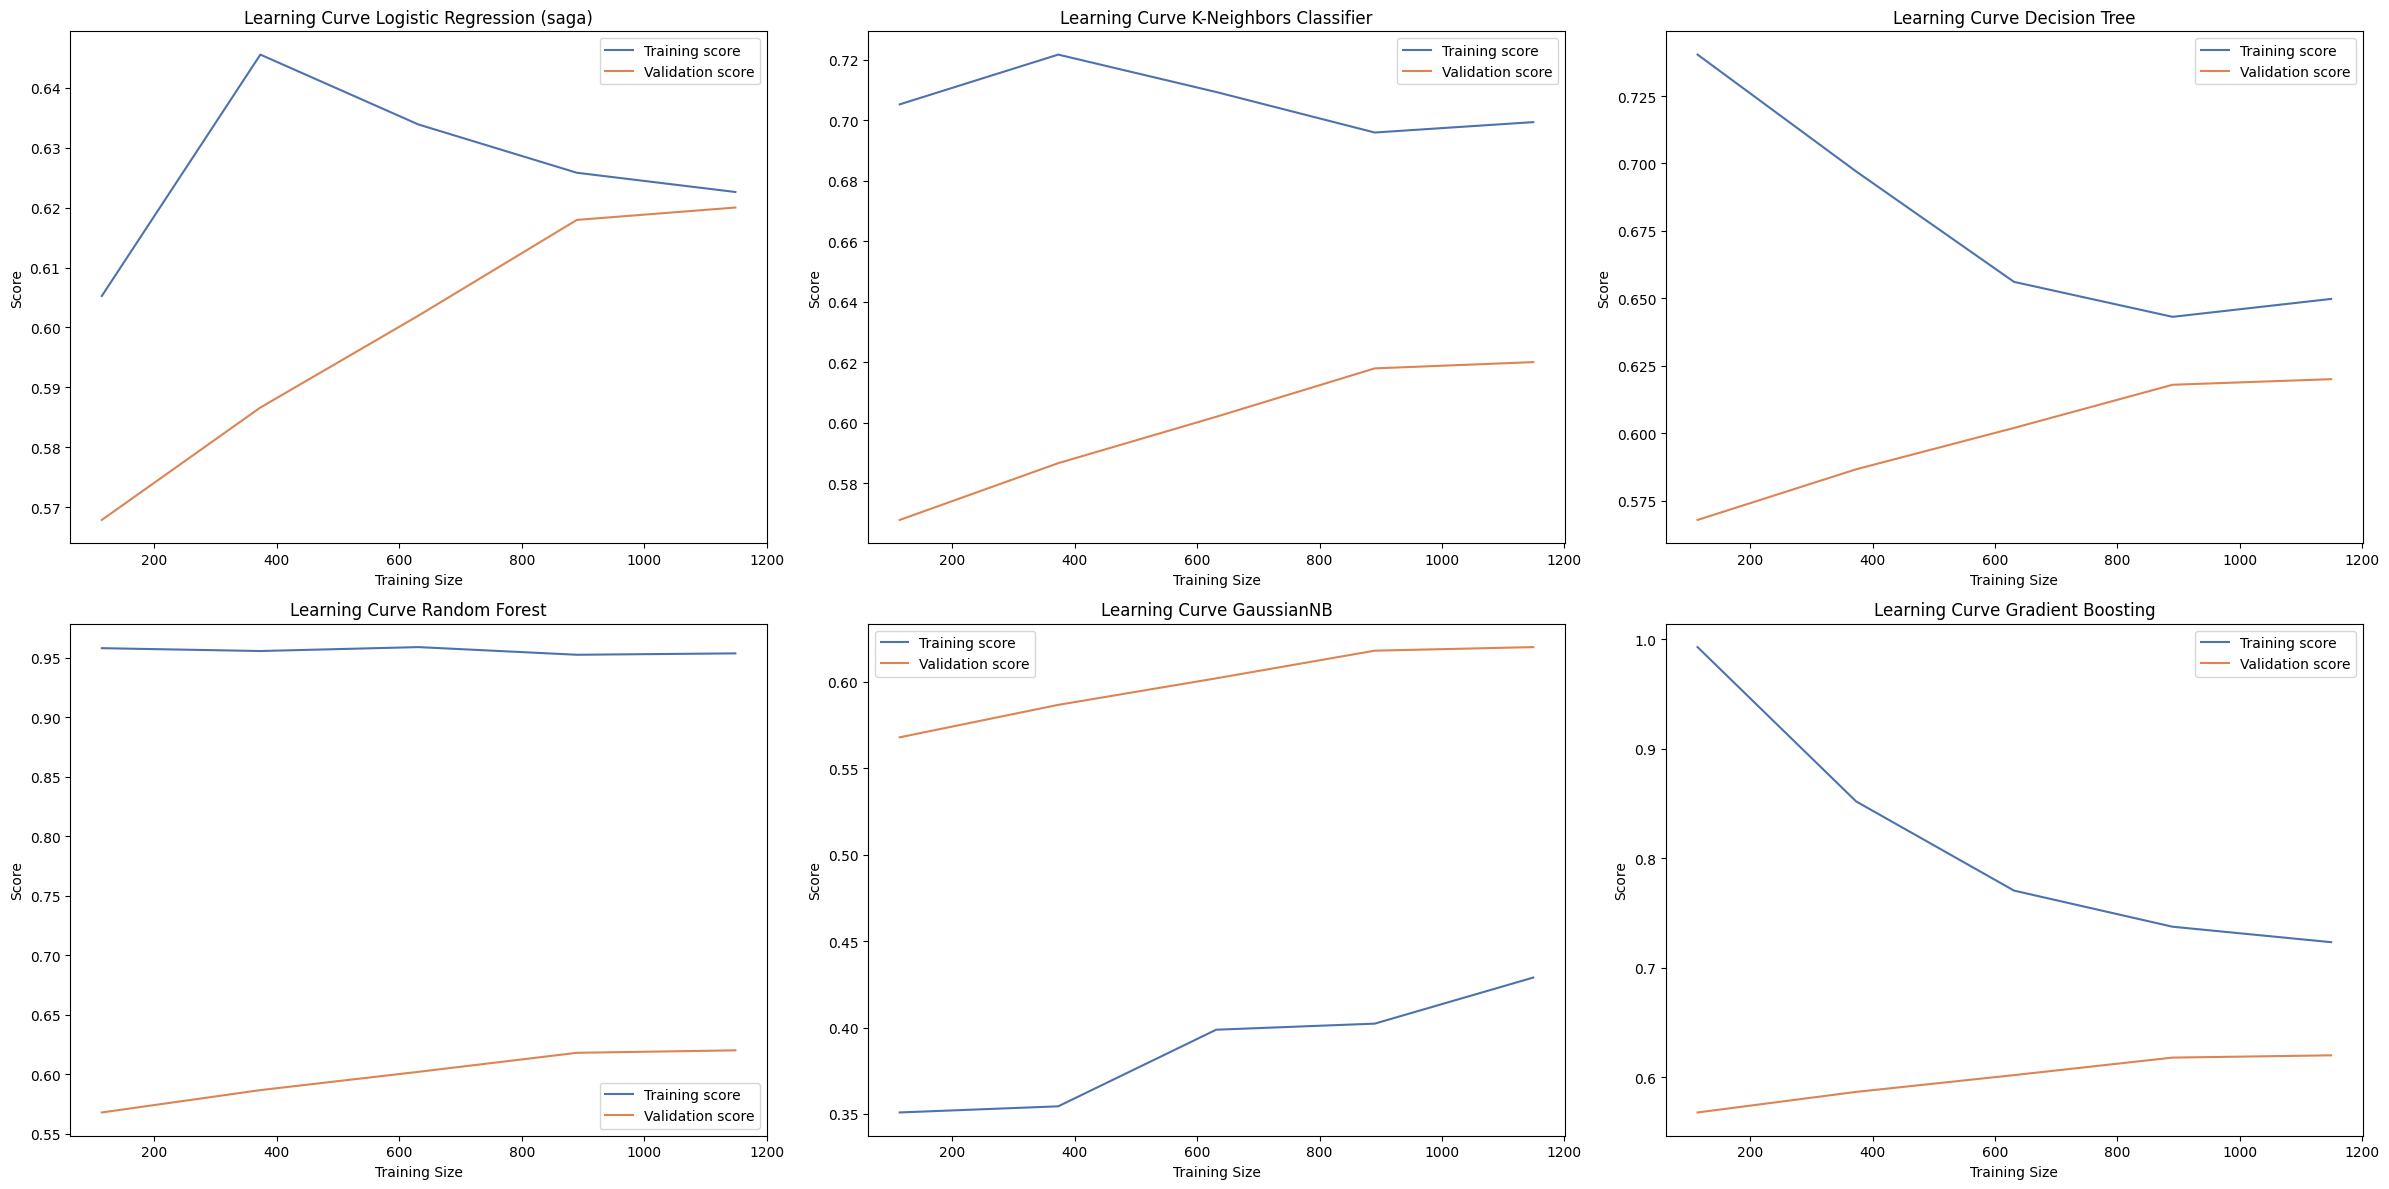

In [26]:
fig, axes = plt.subplots(n_rows, n_cols, figsize=(8 * n_cols, 6 * n_rows))
axes = axes.flatten()
for i, model_name in enumerate(models.keys()):
    train_size = results[model_name]['train_sizes']
    train_scores = results[model_name]['train_scores']
    valid_scores = results[model_name]['validation_scores']
    param_range = np.arange(1, 10, 1)
    axes[i].plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    axes[i].plot(train_sizes, np.mean(validation_scores, axis=1), label='Validation score')
    axes[i].set_title(f'Learning Curve {model_name}')
    axes[i].set_xlabel('Training Size')
    axes[i].set_ylabel('Score')
    axes[i].legend()
for j in range(i + 1, len(axes)):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

* These plots show that `Gaussian NB` is actually underfitting and could benefit from feature engineering to capture patterns effectively. 
* Other models show more or less similar behavior, one having good adjusting to more data, while another start high but drop sharply, like `Logistic Regression`.

After all these observations, the most performing model for our task is `Gradient Boosting`. 